In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
from trainer_test import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = fashion_mnist_classes

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## PLOTTING EMBEDDINGS

In [3]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

## Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [4]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 10
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [5]:
batch_images1 = []
batch_images2 = []
batch_images3 = []
for batch_idx, (data, target) in enumerate(triplet_train_loader):
    target = target if len(target) > 0 else None
    if not type(data) in (tuple, list):
        data = (data,)
    print(len(data[0]))
    print(len(data[1]))
    batch_images1 = data[0]
    batch_images2 = data[1]
    batch_images3 = data[2]
    print(target)
    break


10
10
None


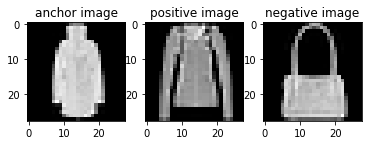

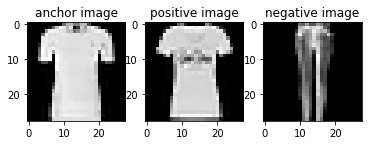

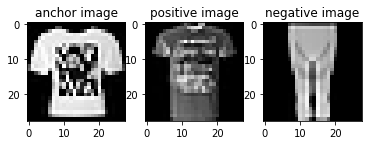

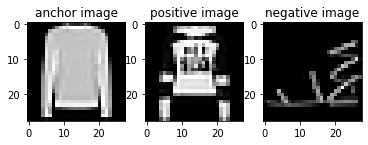

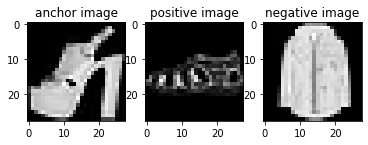

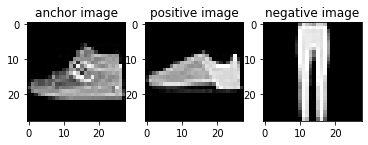

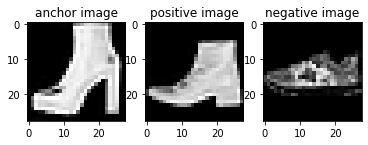

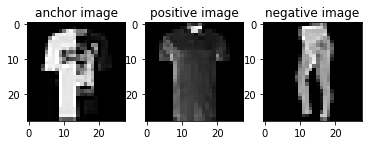

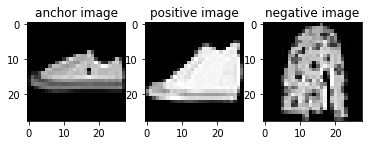

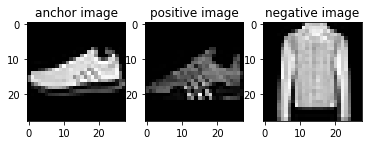

In [6]:
ind = 0
for i in range(len(batch_images1)):
    plt.subplot(131)
    plt.title("anchor image")
    plt.imshow(batch_images1[i].reshape(28,28),cmap="gray")
    plt.subplot(132)
    plt.title("positive image")
    plt.imshow(batch_images2[i].reshape(28,28),cmap="gray")
    plt.subplot(133)
    plt.title("negative image")
    plt.imshow(batch_images3[i].reshape(28,28),cmap="gray")
    plt.show()


# Training

In [7]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [8]:
epochlosses = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, pad

Train: [0/60000 (0%)]	Loss: 0.999595
Train: [12800/60000 (21%)]	Loss: 0.273031
Train: [25600/60000 (43%)]	Loss: 0.197826
Train: [38400/60000 (64%)]	Loss: 0.174088
Train: [51200/60000 (85%)]	Loss: 0.162808
Epoch: 1/20. Train set: Average loss: 0.1978
Epoch: 1/20. Validation set: Average loss: 0.1687
Train: [0/60000 (0%)]	Loss: 0.190159
Train: [12800/60000 (21%)]	Loss: 0.143959
Train: [25600/60000 (43%)]	Loss: 0.140501
Train: [38400/60000 (64%)]	Loss: 0.138152
Train: [51200/60000 (85%)]	Loss: 0.136401
Epoch: 2/20. Train set: Average loss: 0.1386
Epoch: 2/20. Validation set: Average loss: 0.1453
Train: [0/60000 (0%)]	Loss: 0.162758
Train: [12800/60000 (21%)]	Loss: 0.121331
Train: [25600/60000 (43%)]	Loss: 0.130602
Train: [38400/60000 (64%)]	Loss: 0.118915
Train: [51200/60000 (85%)]	Loss: 0.120803
Epoch: 3/20. Train set: Average loss: 0.1216
Epoch: 3/20. Validation set: Average loss: 0.1385
Train: [0/60000 (0%)]	Loss: 0.092953
Train: [12800/60000 (21%)]	Loss: 0.111764
Train: [25600/60000 (

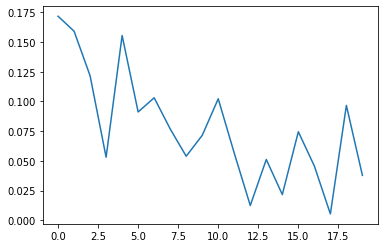

In [9]:
import matplotlib.pyplot as plt 
epochs = []
losses = []
for epoch,loss in epochlosses:
    epochs.append(epoch)
    losses.append(loss[-1])
plt.plot(epochs,losses)
plt.show()


In [10]:
# train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
# plot_embeddings(train_embeddings_baseline, train_labels_baseline)
# val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
# plot_embeddings(val_embeddings_baseline, val_labels_baseline)


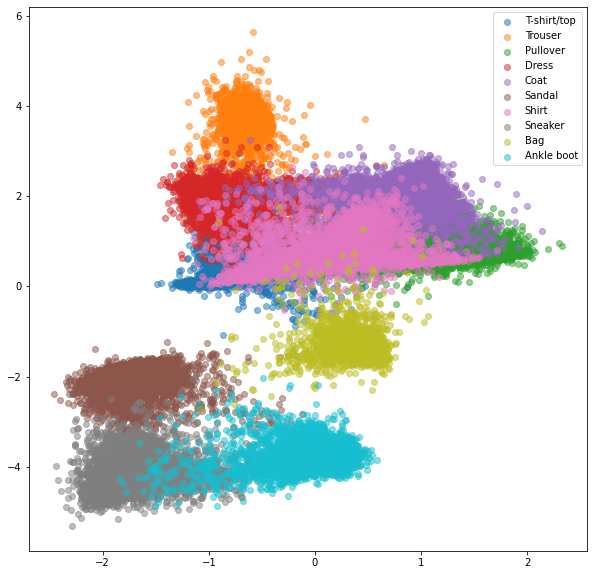

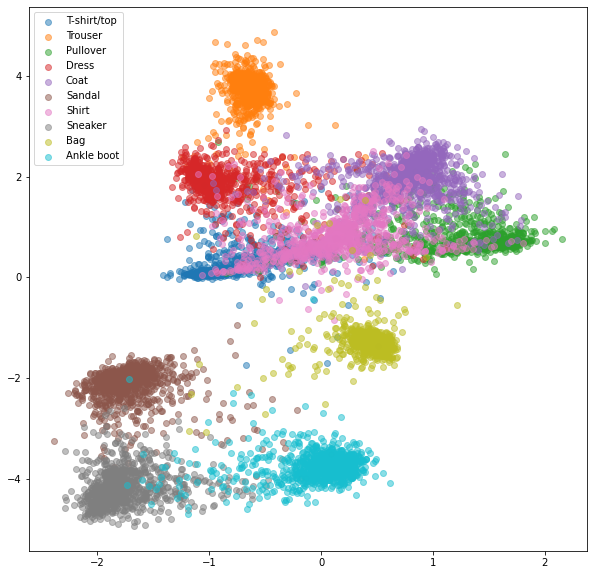

In [11]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

In [12]:
torch.save(model.state_dict(),"triplet_FASHION_MNIST")

In [13]:
model.load_state_dict(torch.load("triplet_FASHION_MNIST"))

<All keys matched successfully>

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Results

In [17]:
with torch.no_grad():
        model.eval()
        difference_coeffs = np.zeros((len(triplet_test_loader.dataset), 2, 2))
        k=0
        for batch_idx, (data,target) in enumerate(triplet_test_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            images0 = data[0]
            images1 = data[1]
            images2 = data[2]
            img0embeddings = model.get_embedding(images0).data.cpu().numpy()
            img1embeddings = model.get_embedding(images1).data.cpu().numpy()
            img2embeddings = model.get_embedding(images2).data.cpu().numpy()
            
            diff = np.array([])
            
            #for every image set in the batch
            for i in range(len(img0embeddings)):
                distance_positive = np.square(img0embeddings[i][0]-img1embeddings[i][0]) + np.square(img0embeddings[i][1]-img1embeddings[i][1])
                distance_negative = np.square(img0embeddings[i][0]-img2embeddings[i][0]) + np.square(img0embeddings[i][1]-img2embeddings[i][1]) 
                
                #normalization of Euclidean Distances
                scaler = MinMaxScaler()
                dist_tar = np.array([[distance_positive,1],[distance_negative,0]])
                scaler.fit(dist_tar)
                dist = scaler.transform(dist_tar)
                    
#                 #print(dist_tar)
                diff = np.append(diff,dist)
                #print(diff)

#             # print(diff.shape)
            diff = np.reshape(diff, (-1, 2, 2))
            difference_coeffs[k:k+len(images0)] = diff
            k += len(images0)

10000


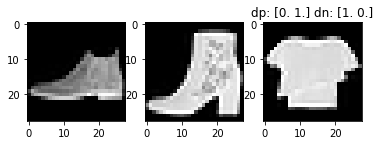

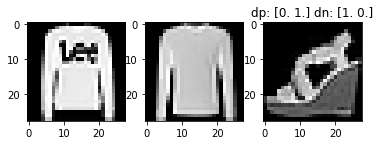

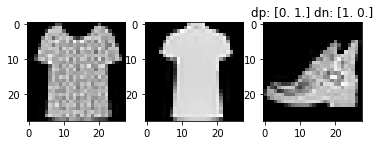

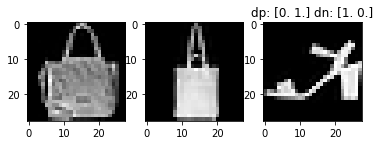

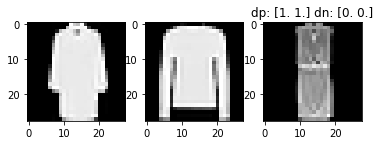

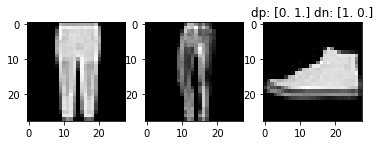

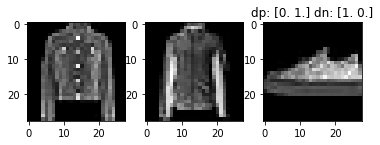

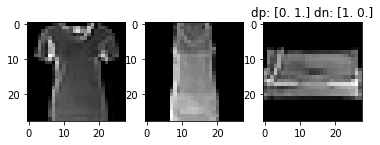

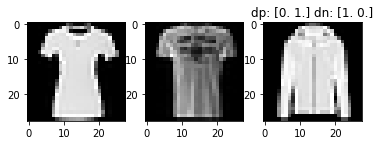

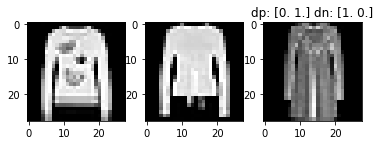

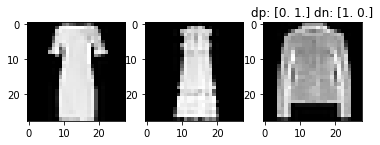

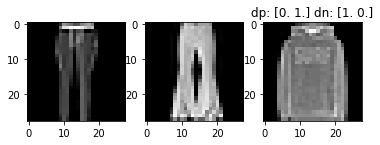

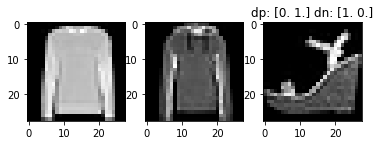

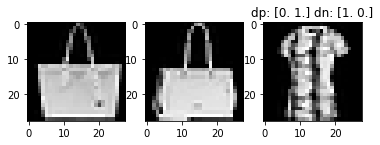

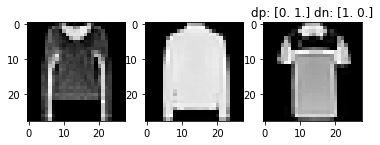

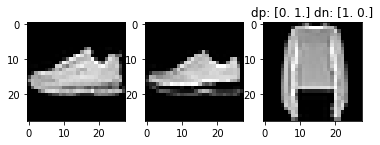

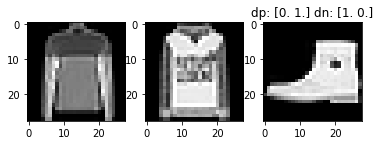

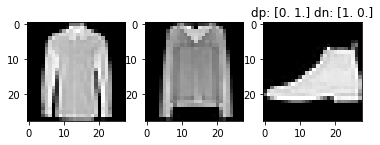

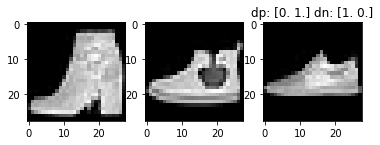

In [18]:
print(len(difference_coeffs))
for i in range(2):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")

for i in range(1000,1001):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(2000,2002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(3000,3002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(4000,4002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(5000,5002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(6000,6002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(7000,7002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(8000,8002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")
    
for i in range(9000,9002):
    sample = triplet_test_loader.dataset[i]
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) 
    plt.title("dp: " + str(difference_coeffs[i][0])+ " dn: " + str(difference_coeffs[i][1]))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")
    ax3.imshow(sample[0][2].reshape(28,28),"gray")

# Visualize Predictions
Based on our results, we can set thresolds as 
positive distance = 0.5 
negative distance = 1
similar images will have the siamese distance < 0.5 and different ones will give a greater distance i.e > 1

In [19]:
threshold_positive = 0.5
threshold_negative = 1

In [20]:
# print(difference_coeffs.shape)
predictions = np.array([])
targets = np.array([])
for x in difference_coeffs:
    #positive
    targets = np.append(targets,1)
    if(x[0][0] <= threshold_positive ):
        predictions = np.append(predictions,1)
    else:
        predictions = np.append(predictions,0)
    #negative
    targets = np.append(targets,0)
    if(x[0][1] >= threshold_positive ):
        predictions = np.append(predictions,0)
    else:
        predictions = np.append(predictions,1)

        
accuracy = len(predictions[predictions == 1])/len(predictions)
print(accuracy*100)

48.585


In [21]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(targets, predictions)

<AxesSubplot:>

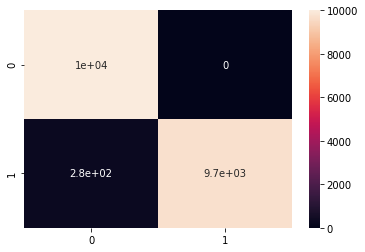

In [22]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [23]:
print(model)

TripletNet(
  (embedding_net): EmbeddingNet(
    (convnet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
)
